# smoothing example

In [1]:
import numpy as np
import pandas as pd
import datetime 
import matplotlib.pyplot as plt 
from smoothing import piecewise_STL

In [2]:
def repair_increasing(allcases):
    """
    fix for the negative value occurring in the daily: x_{t-7} *(X_{t-1}-X_{t-8})/(X_{t-8}-X_{t-15})
    then scaling to get the last cumulative value after negative value appears 
    """
    ind = np.diff(allcases)
    loc_negative = np.where(ind<0)[0]  
    for j in range(len(loc_negative)):
        i_neg = loc_negative[j] + 1 
        if i_neg < 15:
            for i in range(i_neg-1, 0, -1):
                if allcases[i+1] < allcases[i]:
                    allcases[i] = allcases[i+1]
        else: 
            cumul_toscale = allcases[i_neg].copy()
            coeff = (allcases[i_neg-1] - allcases[i_neg-8])/((allcases[i_neg-8] - allcases[i_neg-15])+1)
            daily = (allcases[i_neg-7] - allcases[i_neg-8]) *coeff
            allcases[i_neg] =  allcases[i_neg-1] + daily
            allcases[:i_neg+1] = allcases[:i_neg+1] * cumul_toscale / allcases[i_neg] 
    return allcases 

def read_countries_jhu(df, countries, number_startcases=0):
    """
    read the one dimensional cumulative casts data and the date starting from the day,
    when the number of cases is higher than number-startcases
    """
    allcases_list, date_list = [], []
    for country in countries:
        allcases_ = df[(df["Country/Region"] == country)].drop(["Province/State"],
                                                               axis=1).groupby(["Country/Region"]).sum().to_numpy()
        allcases_ = np.array(allcases_)[0, 4:]
        if np.max(allcases_) >= number_startcases:
            starting_point = np.min(np.where(allcases_ >= number_startcases)[0])
            allcases = allcases_[starting_point:]
         #   allcases = repair_increasing(allcases)
            date_ = pd.to_datetime(df.columns[5:])
            date_ = date_[starting_point:]
        else:
            print(country + " has a number of cases  less than the threshold ", number_startcases)
            allcases = []
            date_ = []
        allcases_list.append(allcases)
        date_list.append(date_)
    return allcases_list, date_list

In [27]:

path_data = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" 
datasource, parse_column = "JHU", "Country/Region"
df = pd.read_csv(path_data) 

In [48]:
countries = ["Germany"]  
cumulative_list, date_list = read_countries_jhu(df, countries)
cumulative = repair_increasing(cumulative_list[0]) 
daily = np.diff(cumulative)

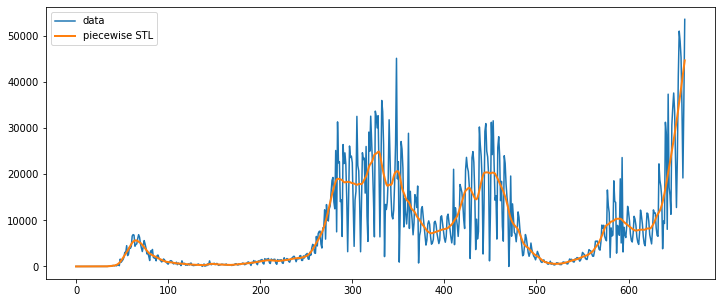

In [11]:
fig, ax = plt.subplots(1,1,figsize = (12,5))
ax.plot(daily)
smoothed = piecewise_STL(cumulative, 0, H=7)
ax.plot(np.diff(smoothed),lw=2)
plt.legend(["data","piecewise STL"]) 

In [103]:

path_data_rki = "D:/EllasDaten/Uni/Wirtschaftsingenieurwesen/6Semester/Bachelorarbeit/Code/Rt_estimate_reconstruction/incidence_data/rtlive_incid_21_07_10.csv" 
datasource = "RKI"
df_rki = pd.read_csv(path_data_rki)

In [104]:
date_list_rki = [pd.DatetimeIndex(df_rki.iloc[:, 0])]
daily_rki = np.array(df_rki.iloc[:,1])
cumulative_rki = np.cumsum(daily_rki)

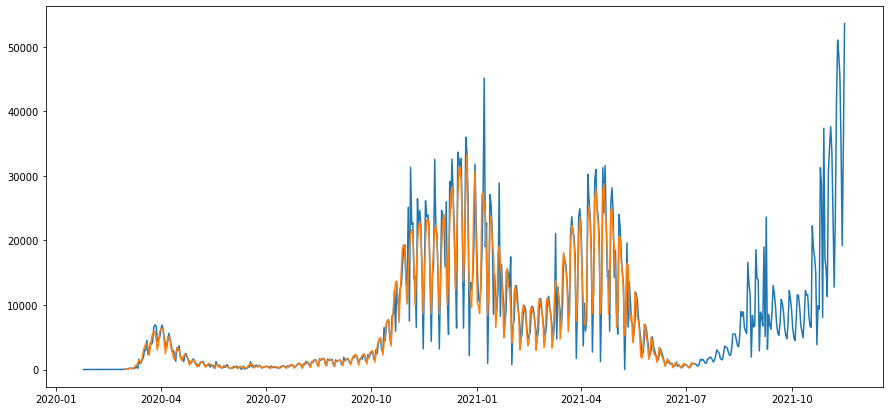

In [105]:
plt.figure(figsize=(15,7))
plt.plot(date_list[0][2:], daily)
plt.plot(date_list_rki[0], daily_rki)
plt.show()

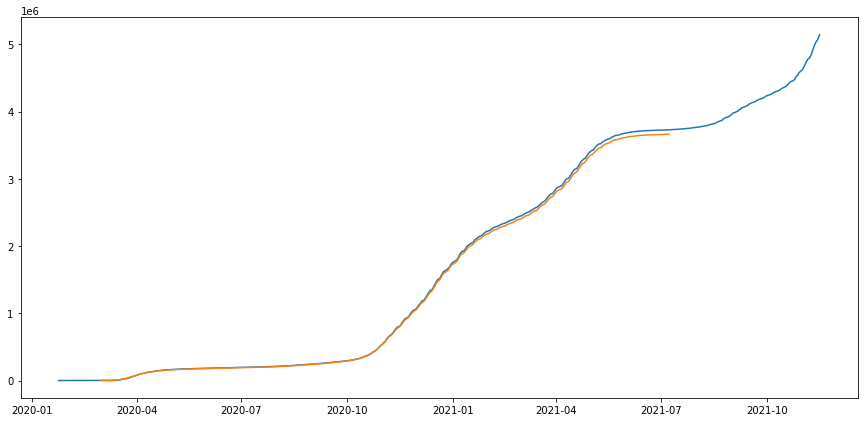

In [106]:
plt.figure(figsize=(15,7))
plt.plot(date_list[0][1:], cumulative)
plt.plot(date_list_rki[0], cumulative_rki)
plt.show()

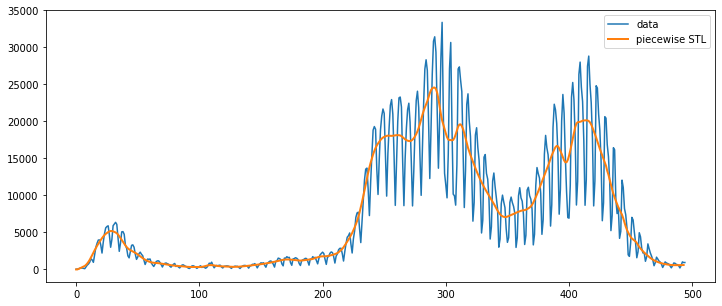

In [123]:
fig, ax = plt.subplots(1,1,figsize = (12,5))
ax.plot(daily_rki)
smoothed_rki = piecewise_STL(cumulative_rki, 0, H=7)
ax.plot(np.diff(smoothed_rki).round(),lw=2)
plt.legend(["data","piecewise STL"])

In [124]:
SDSC_incid = pd.DataFrame({"date":date_list_rki[0][1:], "I":np.diff(smoothed_rki).round()})
SDSC_incid

,date,I
0,2020-03-02,0.0
1,2020-03-03,0.0
2,2020-03-04,72.0
3,2020-03-05,148.0
4,2020-03-06,227.0
...,...,...
489,2021-07-04,583.0
490,2021-07-05,586.0
491,2021-07-06,590.0
492,2021-07-07,593.0


In [126]:
SDSC_incid.to_csv("D:/EllasDaten/Uni/Wirtschaftsingenieurwesen/6Semester/Bachelorarbeit/Code/Rt_estimate_reconstruction/incidence_data/SDSC_incid_21_07_10.csv", index=False)